In [201]:
%load_ext autoreload  
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL

from dataset import TrainDataset, extract_data
from model import HybridLSTMGRU
import evaluation as eval

# Chômage

Dataset extrait chômage :

- Date : 1983-01 à 2024-12
- Zone : France, USA, United Kingdom, Italie
- Mesure: Taux de chomage mensuel
- Unité: Pourcentage de la population active 
- Ajustemenet : corrigé des variations saisonieres, et des effets de calendrier (data_ocde_corr)
- Sexe: Tout 
- Age: 15 ans et plus 

In [83]:
dataset = pd.read_csv("data_ocde_cor.csv", usecols=["TIME_PERIOD",'REF_AREA', "OBS_VALUE"])

pays_avaliable = dataset["REF_AREA"].unique()
pays = "FRA"
dataset

,REF_AREA,TIME_PERIOD,OBS_VALUE
0,USA,2013-08,7.2
1,USA,2013-09,7.2
2,ITA,2002-07,8.6
3,ITA,2002-08,8.6
4,ITA,2002-09,8.6
...,...,...,...
2011,USA,2024-09,4.1
2012,USA,2024-10,4.1
2013,USA,2024-11,4.2
2014,USA,2024-12,4.1


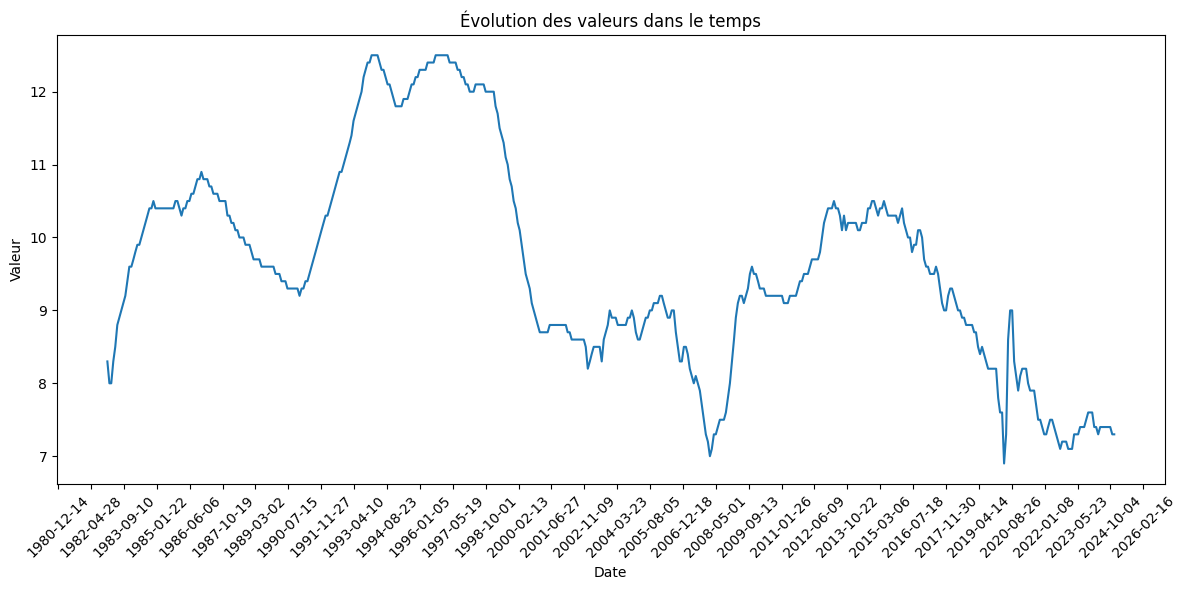

In [84]:
dataset_FRA = dataset[dataset["REF_AREA"] == pays]
dataset_FRA.loc[:, 'TIME_PERIOD'] = pd.to_datetime(dataset_FRA["TIME_PERIOD"])
dataset_FRA = dataset_FRA.sort_values(by='TIME_PERIOD')

plt.figure(figsize=(12, 6))
plt.plot(dataset_FRA['TIME_PERIOD'], dataset_FRA['OBS_VALUE'])
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.title('Évolution des valeurs dans le temps')
plt.xticks(rotation=45)

# Formatage auto de l'axe x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(40))  # max 10 dates visibles
plt.tight_layout()
plt.show()

# Séparation Entrainement/Validation/Test pour les données de chômage

In [105]:
from torch.utils.data import DataLoader

pays = "FRA"
type = 'chomage'
prop = [0.7, 0.15, 0.15]
scaler=MinMaxScaler()
seq_len = 6
batchsize = 32
shift = 1

train_data, val_data, test_data = extract_data(dataset, pays, prop, type, scaler=scaler)
dataset_train = TrainDataset(train_data, seq_len=seq_len, shift=shift)
train_dataloader = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)

Type : chomage


In [ ]:
from torch import nn
import torch.optim as optim
import train_plot

DEVICE = "cuda"

model = HybridLSTMGRU().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 1500
train_plot.metric_start_plot()
for epoch in range(EPOCHS):
    model.train()
    for X, y in train_dataloader:
        X = X.unsqueeze(-1).to(DEVICE)
        y = y.unsqueeze(-1).to(DEVICE)
        
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
    if (epoch-1) % 100 == 0:
        #train_plot.metric_plot_values(model, train_data, val_data, seq_len, scaler, epoch)
        train_rmse, train_mae, train_mape = eval.evaluate(model, train_data, None, seq_len, scaler)
        val_rmse, val_mae, val_mape = eval.evaluate(model, val_data, train_data, seq_len, scaler)
        print(f"Epoch {epoch}/{EPOCHS}")
        print(f"Training - RMSE: {train_rmse:.4f},  MAE: {train_mae:.4f}, MAPE: {train_mape:.4f}")
        print(f"Validation - RMSE: {val_rmse:.4f},  MAE: {val_mae:.4f}, MAPE: {val_mape:.4f}")
    
train_plot.metric_end_plot()

Epoch 1/1500
Training - RMSE: 1.2417,  MAE: 0.9918, MAPE: 0.0966
Validation - RMSE: 0.4873,  MAE: 0.4390, MAPE: 0.0438
Epoch 101/1500
Training - RMSE: 0.1194,  MAE: 0.0926, MAPE: 0.0097
Validation - RMSE: 0.1555,  MAE: 0.1274, MAPE: 0.0129
Epoch 201/1500
Training - RMSE: 0.0869,  MAE: 0.0634, MAPE: 0.0067
Validation - RMSE: 0.1184,  MAE: 0.0948, MAPE: 0.0096
Epoch 301/1500
Training - RMSE: 0.0805,  MAE: 0.0601, MAPE: 0.0063
Validation - RMSE: 0.1119,  MAE: 0.0885, MAPE: 0.0089
Epoch 401/1500
Training - RMSE: 0.0796,  MAE: 0.0603, MAPE: 0.0063
Validation - RMSE: 0.1107,  MAE: 0.0877, MAPE: 0.0088
Epoch 501/1500
Training - RMSE: 0.0819,  MAE: 0.0636, MAPE: 0.0067
Validation - RMSE: 0.1123,  MAE: 0.0888, MAPE: 0.0089
Epoch 601/1500
Training - RMSE: 0.0800,  MAE: 0.0587, MAPE: 0.0062
Validation - RMSE: 0.1117,  MAE: 0.0886, MAPE: 0.0089
Epoch 701/1500
Training - RMSE: 0.0803,  MAE: 0.0605, MAPE: 0.0063
Validation - RMSE: 0.1114,  MAE: 0.0885, MAPE: 0.0089
Epoch 801/1500
Training - RMSE: 0.

Test - RMSE: 1.4761,  MAE: 0.7539, MAPE: 0.1367
Naive - RMSE: 1.2721,  MAE: 0.3526, MAPE: 0.0464


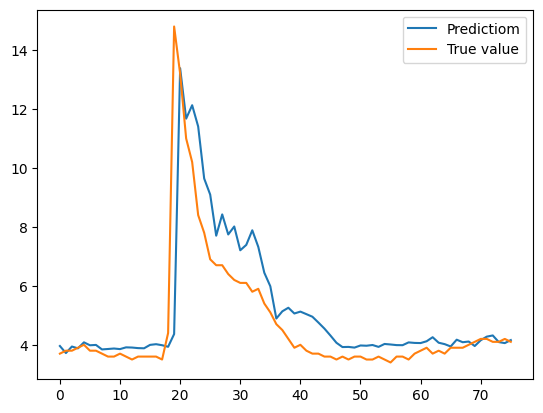

In [ ]:

test_rmse, test_mae, test_mape = eval.evaluate(model, test_data, val_data, seq_len, scaler)
naive_rmse, naive_mae, naive_mape = eval.evaluate_naive(test_data, val_data, seq_len, scaler)

print(f"Test - RMSE: {test_rmse:.4f},  MAE: {test_mae:.4f}, MAPE: {test_mape:.4f}")
print(f"Naive - RMSE: {naive_rmse:.4f},  MAE: {naive_mae:.4f}, MAPE: {naive_mape:.4f}")

eval.plot_prediction(model, test_data, val_data, seq_len, scaler)


# Températures

#### Comparer les résultats entre les modèles testés et parler du meilleur modèle

#### Meilleur modèle bien meilleur que le naif dans ce cas en raison des changements drastiques ce qui n'est pas le cas pour le chomage pas autant dépendant du mois

#### Comparer meilleur modèle température vs chômage. Est-ce le même? Est-ce qu'il performe mieux sur un type de données?

#### Potentiellement voir si le meilleur modèle change pour différents pays et si meilleures performances

#### Voir si même modèle optimal pour désaisonnalisé vs pas désaisonnalisé et quel performe mieux

#### Conclusion on peut voir que le type de données affecte les performances de ce modèle qui performe mieux sur les données températures que sur les données de chômage, puisque naif meilleur pour chômage mais pas le cas pour température. Cela peut être dû au fait que le chômage dépend plus de sa dernière valeur tandis que les températures changent plus drastiquement on peut penser par exemple au mois de décembre vs janvier peut-être. Il est donc pas bon de garder valeur de décembre comme prédiction pour janvier tandis que oui pour le chômage.

In [192]:
dataset_temp = pd.read_csv("city_temperatures.csv", usecols=["Year", 'Month', 'Day', 'Country', 'City', 'AvgTemperature'])
dataset_temp

,Country,City,Month,Day,Year,AvgTemperature
0,France,Paris,1,1,1995,37.4
1,France,Paris,1,2,1995,35.2
2,France,Paris,1,3,1995,36.0
3,France,Paris,1,4,1995,30.7
4,France,Paris,1,5,1995,27.0
...,...,...,...,...,...,...
55591,United Kingdom,London,5,9,2020,64.1
55592,United Kingdom,London,5,10,2020,54.1
55593,United Kingdom,London,5,11,2020,47.0
55594,United Kingdom,London,5,12,2020,48.9


In [193]:
# Puisqu'il y a des valeurs de -99 Farenheit pour certaines journnées, on peut assumer que celles-ci sont le résultat de valeurs manquantes
# On peut donc enlever ces valeurs de l'ensemble de données

dataset_temp = dataset_temp[dataset_temp['AvgTemperature'] > 0].reset_index(drop=True)
dataset_temp

,Country,City,Month,Day,Year,AvgTemperature
0,France,Paris,1,1,1995,37.4
1,France,Paris,1,2,1995,35.2
2,France,Paris,1,3,1995,36.0
3,France,Paris,1,4,1995,30.7
4,France,Paris,1,5,1995,27.0
...,...,...,...,...,...,...
55358,United Kingdom,London,5,9,2020,64.1
55359,United Kingdom,London,5,10,2020,54.1
55360,United Kingdom,London,5,11,2020,47.0
55361,United Kingdom,London,5,12,2020,48.9


In [194]:
# Par la suite, on transforme les données pour avoir une moyenne des températures à chaque mois plutôt qu'à chaque année

dataset_temp_mensuel = dataset_temp.groupby(['Country', 'City', 'Year', 'Month'])['AvgTemperature'].mean().reset_index()
dataset_temp_mensuel

,Country,City,Year,Month,AvgTemperature
0,France,Bordeaux,1995,1,44.435484
1,France,Bordeaux,1995,2,49.217857
2,France,Bordeaux,1995,3,48.548387
3,France,Bordeaux,1995,4,53.846667
4,France,Bordeaux,1995,5,61.429032
...,...,...,...,...,...
1825,United Kingdom,London,2020,1,45.270968
1826,United Kingdom,London,2020,2,45.789655
1827,United Kingdom,London,2020,3,45.500000
1828,United Kingdom,London,2020,4,53.326667


In [195]:
dataset_temp_mensuel['Time Period'] = dataset_temp_mensuel['Year'].astype(str) + '-' + dataset_temp_mensuel['Month'].astype(str)
dataset_temp_mensuel.loc[:, 'Time Period'] = pd.to_datetime(dataset_temp_mensuel['Time Period']).dt.date
dataset_temp_mensuel

,Country,City,Year,Month,AvgTemperature,Time Period
0,France,Bordeaux,1995,1,44.435484,1995-01-01
1,France,Bordeaux,1995,2,49.217857,1995-02-01
2,France,Bordeaux,1995,3,48.548387,1995-03-01
3,France,Bordeaux,1995,4,53.846667,1995-04-01
4,France,Bordeaux,1995,5,61.429032,1995-05-01
...,...,...,...,...,...,...
1825,United Kingdom,London,2020,1,45.270968,2020-01-01
1826,United Kingdom,London,2020,2,45.789655,2020-02-01
1827,United Kingdom,London,2020,3,45.500000,2020-03-01
1828,United Kingdom,London,2020,4,53.326667,2020-04-01


In [196]:
# On fait le modèle pour les températures moyennes par mois à Paris en France

pays = 'France'
ville = 'Paris'

dataset_temp_mensuel_Paris = dataset_temp_mensuel[(dataset_temp_mensuel["City"] == ville) & (dataset_temp_mensuel["Country"] == pays)].reset_index(drop=True)
dataset_temp_mensuel_Paris = dataset_temp_mensuel_Paris.sort_values(by='Time Period')
dataset_temp_mensuel_Paris

,Country,City,Year,Month,AvgTemperature,Time Period
0,France,Paris,1995,1,42.158065,1995-01-01
1,France,Paris,1995,2,48.160714,1995-02-01
2,France,Paris,1995,3,45.938710,1995-03-01
3,France,Paris,1995,4,51.226667,1995-04-01
4,France,Paris,1995,5,60.041935,1995-05-01
...,...,...,...,...,...,...
300,France,Paris,2020,1,43.432258,2020-01-01
301,France,Paris,2020,2,47.441379,2020-02-01
302,France,Paris,2020,3,47.103226,2020-03-01
303,France,Paris,2020,4,57.176667,2020-04-01


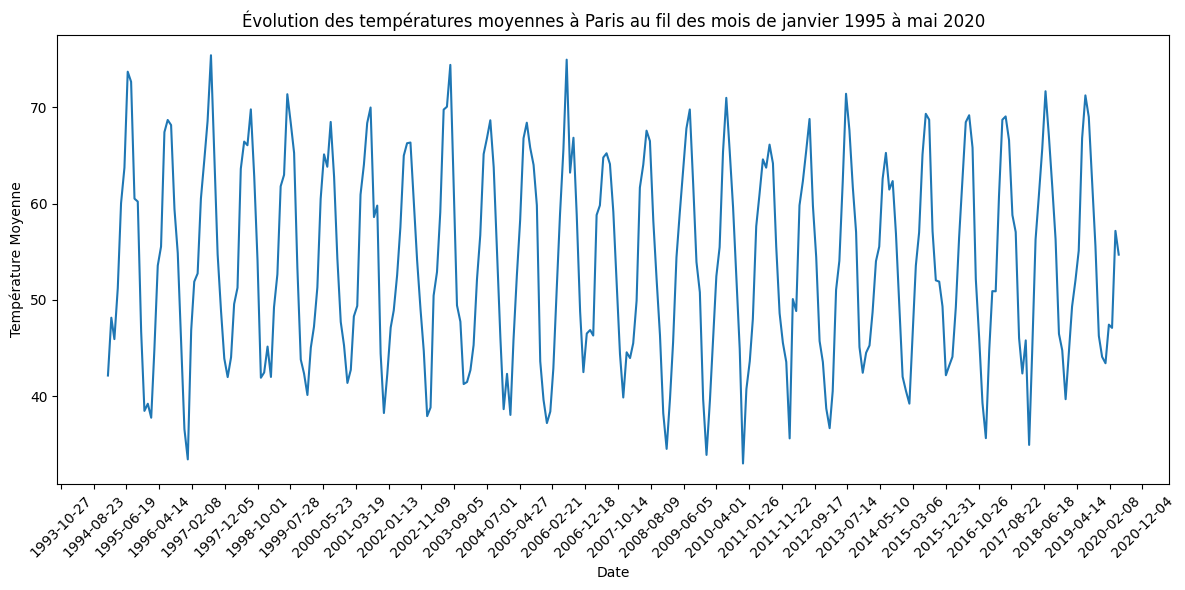

In [198]:
# On visualise la série chronologique

plt.figure(figsize=(12, 6))
plt.plot(dataset_temp_mensuel_Paris['Time Period'], dataset_temp_mensuel_Paris['AvgTemperature'])
plt.xlabel('Date')
plt.ylabel('Température Moyenne')
plt.title('Évolution des températures moyennes à Paris au fil des mois de janvier 1995 à mai 2020')
plt.xticks(rotation=45)

# Formatage auto de l'axe x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(40))  # max 10 dates visibles
plt.tight_layout()
plt.show()

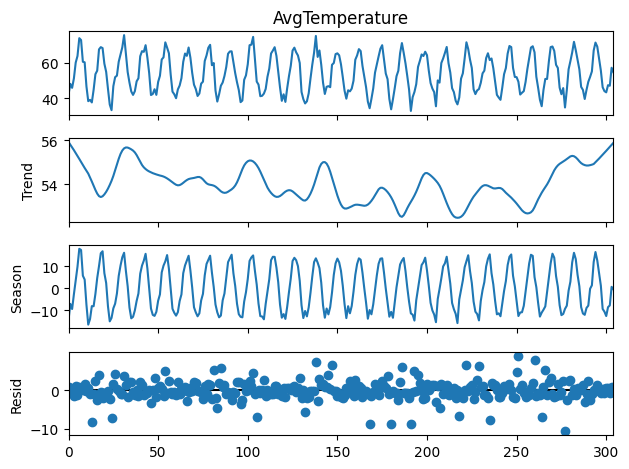

In [199]:
# Comme les données du chômage étaient désaisonnalisées, on effectue le même traitement pour ces données qui ont clairement une saisonnalité
# sur les 12 mois de l'année

stl = STL(dataset_temp_mensuel_Paris['AvgTemperature'], period = 12, robust = True)
res = stl.fit()

dataset_temp_mensuel_Paris['Saisonnalité'] = res.seasonal
dataset_temp_mensuel_Paris['AvgTemperature Adjusted'] = dataset_temp_mensuel_Paris['AvgTemperature'] - dataset_temp_mensuel_Paris['Saisonnalité']

res.plot()
plt.show()

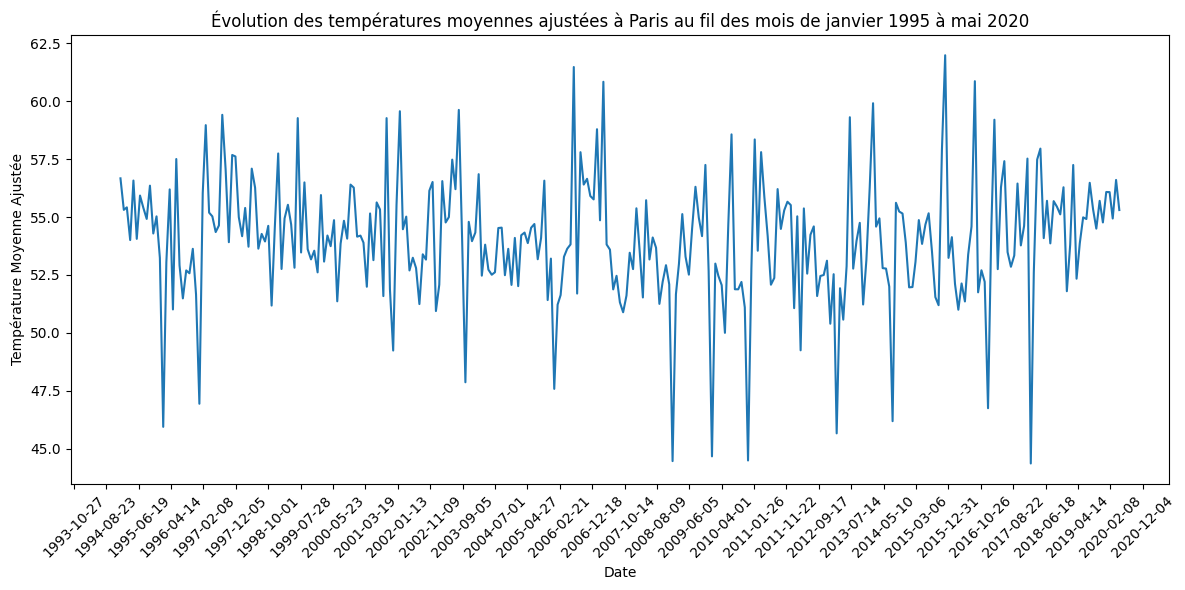

In [200]:
# On visualise la série chronologique désaisonnalisée

plt.figure(figsize=(12, 6))
plt.plot(dataset_temp_mensuel_Paris['Time Period'], dataset_temp_mensuel_Paris['AvgTemperature Adjusted'])
plt.xlabel('Date')
plt.ylabel('Température Moyenne Ajustée')
plt.title('Évolution des températures moyennes ajustées à Paris au fil des mois de janvier 1995 à mai 2020')
plt.xticks(rotation=45)

# Formatage auto de l'axe x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(40))  # max 10 dates visibles
plt.tight_layout()
plt.show()

# On trouve les meilleurs hyper-paramètres pour lr, seq_len et batch size pour les données sur la température désaisonnalisée pour les données de Paris, France

In [ ]:
from itertools import product
import copy
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
import train_plot
from evaluation import set_seed

# Paramètres fixes du modèle 
pays_temp = 'France'
ville_temp = 'Paris'
type = 'temperature'
saison = False
prop = [0.7, 0.15, 0.15]
shift_temp = 1
DEVICE = "cpu"
EPOCHS = 1500
scaler=MinMaxScaler()

# Hyper-paramètres testés
lrs_temp = [0.01, 0.001, 0.0001]
seq_lens_temp = list(range(3, 25, 3))
batchsizes_temp = [16, 32, 64]

# On obtient les données qui seront utilisées pour entrainer le modèle
train_data_temp, val_data_temp, test_data_temp = extract_data(dataset_temp, pays_temp, prop, type, saison, ville = ville_temp, scaler=scaler)

# Pour stocker les métriques des modèles testés
best_results_all = []

for lr, seq_len, batch_size in product(lrs_temp, seq_lens_temp, batchsizes_temp):
    print(f"Combinaison testée: lr={lr}, seq_len={seq_len}, batch_size={batch_size}")
    set_seed(42)

    dataset_train_temp = TrainDataset(train_data_temp, seq_len=seq_len, shift=shift_temp)
    train_dataloader_temp = DataLoader(dataset_train_temp, batch_size=batch_size, shuffle=True)

    # On initialise le modèle
    model_temp = HybridLSTMGRU().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_temp.parameters(), lr=lr)
    
    # On se prépare à noter les métriques pour le meilleur modèle de la combinaison testée
    best_val_rmse = float("inf")
    best_model = None
    best_epoch = 0
    best_val_mae = None
    best_val_mape = None
    best_train_rmse = None
    best_train_mae = None
    best_train_mape = None

    train_plot.metric_start_plot()
    for epoch in range(EPOCHS):
        model_temp.train()
        for X, y in train_dataloader_temp:
            X = X.unsqueeze(-1).to(DEVICE)
            y = y.unsqueeze(-1).to(DEVICE)
            
            optimizer.zero_grad()
            output = model_temp(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
        if (epoch-1) % 50 == 0:
            #train_plot.metric_plot_values(model, train_data, val_data, seq_len, scaler, epoch)
            train_rmse_temp, train_mae_temp, train_mape_temp = eval.evaluate(model_temp, train_data_temp, None, seq_len, scaler)
            val_rmse_temp, val_mae_temp, val_mape_temp = eval.evaluate(model_temp, val_data_temp, train_data_temp, seq_len, scaler)
            print(f"Epoch {epoch}/{EPOCHS}")
            print(f"Training - RMSE: {train_rmse_temp:.4f},  MAE: {train_mae_temp:.4f}, MAPE: {train_mape_temp:.4f}")
            print(f"Validation - RMSE: {val_rmse_temp:.4f},  MAE: {val_mae_temp:.4f}, MAPE: {val_mape_temp:.4f}")
            
            if val_rmse_temp < best_val_rmse:
                best_val_rmse = val_rmse_temp
                best_epoch = epoch
                best_train_rmse = train_rmse_temp
                best_model = copy.deepcopy(model_temp)
                best_val_mae = val_mae_temp
                best_val_mape = val_mape_temp
                best_train_mae = train_mae_temp
                best_train_mape = train_mape_temp
        
    print(f"Meilleure RMSE de validation est de {best_val_rmse} pour {best_epoch} epochs")    
    train_plot.metric_end_plot()

    # On évalue le modèle sur les données test
    test_rmse_temp, test_mae_temp, test_mape_temp = eval.evaluate(best_model, test_data_temp, val_data_temp, seq_len, scaler)
    print(f"Test - RMSE: {test_rmse_temp:.4f},  MAE: {test_mae_temp:.4f}, MAPE: {test_mape_temp:.4f}")
    
    # Stocker les résultats pour cette combinaison dans un dictionnaire
    result = {
        "lr": lr,
        "seq_len": seq_len,
        "batch_size": batch_size,
        "best_epoch": best_epoch,
        "train_rmse": best_train_rmse,
        "val_rmse": best_val_rmse,
        "test_rmse": test_rmse_temp,
        "test_mae": test_mae_temp,
        "test_mape": test_mape_temp
    }

    # On ajoute les résulats à la liste des résultats pour cette combinaison
    best_results_all.append(result)

results_df = pd.DataFrame(best_results_all)
results_df

Type : temperature
Combinaison testée: lr=0.01, seq_len=3, batch_size=16
Epoch 1/1500
Training - RMSE: 2.5816,  MAE: 1.8613, MAPE: 0.0350
Validation - RMSE: 2.9275,  MAE: 2.1527, MAPE: 0.0408
Epoch 51/1500
Training - RMSE: 2.5763,  MAE: 1.8703, MAPE: 0.0348
Validation - RMSE: 2.8056,  MAE: 1.9333, MAPE: 0.0363
Epoch 101/1500
Training - RMSE: 2.5530,  MAE: 1.8519, MAPE: 0.0345
Validation - RMSE: 2.8074,  MAE: 1.9230, MAPE: 0.0361
Epoch 151/1500
Training - RMSE: 2.4870,  MAE: 1.8040, MAPE: 0.0340
Validation - RMSE: 2.8970,  MAE: 2.0930, MAPE: 0.0395
Epoch 201/1500
Training - RMSE: 2.4097,  MAE: 1.7544, MAPE: 0.0329
Validation - RMSE: 2.6508,  MAE: 1.9308, MAPE: 0.0363
Epoch 251/1500
Training - RMSE: 2.2736,  MAE: 1.6339, MAPE: 0.0307
Validation - RMSE: 2.4951,  MAE: 1.9478, MAPE: 0.0369
Epoch 301/1500
Training - RMSE: 2.1577,  MAE: 1.5521, MAPE: 0.0290
Validation - RMSE: 2.5259,  MAE: 2.0485, MAPE: 0.0388
Epoch 351/1500
Training - RMSE: 2.1419,  MAE: 1.5618, MAPE: 0.0295
Validation - RMS

,lr,seq_len,batch_size,best_epoch,train_rmse,val_rmse,test_rmse,test_mae,test_mape
0,0.0100,3,16,251,2.273574,2.495072,2.591207,1.858203,0.034610
1,0.0100,3,32,251,2.278132,2.555556,2.729847,1.965011,0.036514
2,0.0100,3,64,351,2.236020,2.407467,2.757729,1.983807,0.036880
3,0.0100,6,16,51,2.666876,2.824451,3.103931,2.403602,0.044092
4,0.0100,6,32,801,0.004546,2.798144,3.900281,2.604220,0.048323
...,...,...,...,...,...,...,...,...,...
67,0.0001,21,32,1201,2.541708,2.808584,2.924053,2.134198,0.039593
68,0.0001,21,64,1201,2.539457,2.832231,2.905777,2.098323,0.038978
69,0.0001,24,16,1251,2.483542,2.734625,2.895606,2.157743,0.040009
70,0.0001,24,32,1151,2.553105,2.816766,2.906502,2.107785,0.039150


In [ ]:
# On crée un csv pour les résultats des différentes combinaisons
results_df.to_csv('Recherche_hypeparametres_temperatures.csv', index = False)

In [224]:
# On regarde quelle combinaison s'hyper-paramètres à donner la meilleure valeur de RMSE test
best_row = results_df.loc[results_df['test_rmse'].idxmin()]
best_row

lr              0.010000
seq_len         3.000000
batch_size     16.000000
best_epoch    251.000000
train_rmse      2.273574
val_rmse        2.495072
test_rmse       2.591207
test_mae        1.858203
test_mape       0.034610
Name: 0, dtype: float64

Type : temperature
Epoch 1/252
Training - RMSE: 2.5816,  MAE: 1.8613, MAPE: 0.0350
Validation - RMSE: 2.9275,  MAE: 2.1527, MAPE: 0.0408
Epoch 51/252
Training - RMSE: 2.5763,  MAE: 1.8703, MAPE: 0.0348
Validation - RMSE: 2.8056,  MAE: 1.9333, MAPE: 0.0363
Epoch 101/252
Training - RMSE: 2.5530,  MAE: 1.8519, MAPE: 0.0345
Validation - RMSE: 2.8074,  MAE: 1.9230, MAPE: 0.0361
Epoch 151/252
Training - RMSE: 2.4870,  MAE: 1.8040, MAPE: 0.0340
Validation - RMSE: 2.8970,  MAE: 2.0930, MAPE: 0.0395
Epoch 201/252
Training - RMSE: 2.4097,  MAE: 1.7544, MAPE: 0.0329
Validation - RMSE: 2.6508,  MAE: 1.9308, MAPE: 0.0363
Epoch 251/252
Training - RMSE: 2.2736,  MAE: 1.6339, MAPE: 0.0307
Validation - RMSE: 2.4951,  MAE: 1.9478, MAPE: 0.0369
Test - RMSE: 2.5912,  MAE: 1.8582, MAPE: 0.0346
Naive - RMSE: 3.9073,  MAE: 2.7542, MAPE: 0.0519


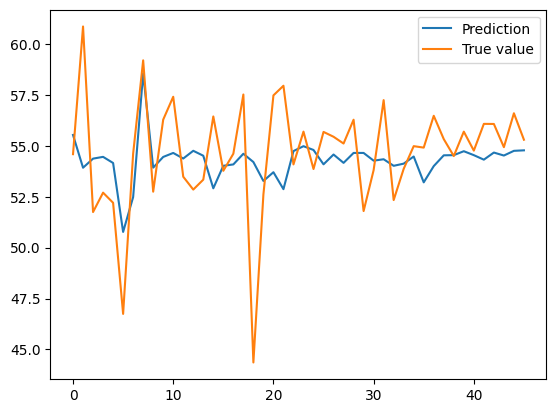

In [232]:
# On réentraine donc le modèle avec le même seed (42), puis on obtient le graphique des prédictions et des valeurs réelles
# On compare également les performances du modèle contre les performances d'un modèle naif

# Paramètres fixes du modèle 
pays_temp = 'France'
ville_temp = 'Paris'
type = 'temperature'
saison = False
prop = [0.7, 0.15, 0.15]
shift_temp = 1
DEVICE = "cpu"
scaler=MinMaxScaler()

# Paramètres optimaux
EPOCHS_opt = 252
lr_opt = 0.01
seq_len_opt = 3
batch_size_opt = 16

set_seed(42)

# On obtient les données qui seront utilisées pour entrainer le modèle
train_data_temp, val_data_temp, test_data_temp = extract_data(dataset_temp, pays_temp, prop, type, saison, ville = ville_temp, scaler=scaler)
dataset_train_temp = TrainDataset(train_data_temp, seq_len=seq_len_opt, shift=shift_temp)
train_dataloader_temp = DataLoader(dataset_train_temp, batch_size=batch_size_opt, shuffle=True)

# On initialise le modèle
model_temp = HybridLSTMGRU().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_temp.parameters(), lr=lr_opt)

train_plot.metric_start_plot()
for epoch in range(EPOCHS_opt):
    model_temp.train()
    for X, y in train_dataloader_temp:
        X = X.unsqueeze(-1).to(DEVICE)
        y = y.unsqueeze(-1).to(DEVICE)
        
        optimizer.zero_grad()
        output = model_temp(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
    if (epoch) % 50 == 1:
        #train_plot.metric_plot_values(model, train_data, val_data, seq_len, scaler, epoch)
        train_rmse_temp, train_mae_temp, train_mape_temp = eval.evaluate(model_temp, train_data_temp, None, seq_len_opt, scaler)
        val_rmse_temp, val_mae_temp, val_mape_temp = eval.evaluate(model_temp, val_data_temp, train_data_temp, seq_len_opt, scaler)
        print(f"Epoch {epoch}/{EPOCHS_opt}")
        print(f"Training - RMSE: {train_rmse_temp:.4f},  MAE: {train_mae_temp:.4f}, MAPE: {train_mape_temp:.4f}")
        print(f"Validation - RMSE: {val_rmse_temp:.4f},  MAE: {val_mae_temp:.4f}, MAPE: {val_mape_temp:.4f}")
       
train_plot.metric_end_plot()

# On évalue le modèle sur les données test
test_rmse_temp, test_mae_temp, test_mape_temp = eval.evaluate(model_temp, test_data_temp, val_data_temp, seq_len_opt, scaler)
naive_rmse_temp, naive_mae_temp, naive_mape_temp = eval.evaluate_naive(test_data_temp, val_data_temp, seq_len_opt, scaler)

print(f"Test - RMSE: {test_rmse_temp:.4f},  MAE: {test_mae_temp:.4f}, MAPE: {test_mape_temp:.4f}")
print(f"Naive - RMSE: {naive_rmse_temp:.4f},  MAE: {naive_mae_temp:.4f}, MAPE: {naive_mape_temp:.4f}")

eval.plot_prediction(model_temp, test_data_temp, val_data_temp, seq_len_opt, scaler)

# On trouve les meilleurs hyper-paramètres pour lr, seq_len et batch size pour les données sur la température qui ne sont pas désaisonnalisées pour les données de Paris, France

In [ ]:
from itertools import product
import copy
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
import train_plot
from evaluation import set_seed

# Paramètres fixes du modèle 
pays_temp = 'France'
ville_temp = 'Paris'
type = 'temperature'
saison = True
prop = [0.7, 0.15, 0.15]
shift_temp = 1
DEVICE = "cpu"
EPOCHS = 1500
scaler=MinMaxScaler()

# Hyper-paramètres testés
lrs_temp = [0.01, 0.001, 0.0001]
seq_lens_temp = list(range(3, 25, 3))
batchsizes_temp = [16, 32, 64]

# On obtient les données qui seront utilisées pour entrainer le modèle
train_data_temp, val_data_temp, test_data_temp = extract_data(dataset_temp, pays_temp, prop, type, saison, ville = ville_temp, scaler=scaler)

# Pour stocker les métriques des modèles testés
best_results_all = []

for lr, seq_len, batch_size in product(lrs_temp, seq_lens_temp, batchsizes_temp):
    print(f"Combinaison testée: lr={lr}, seq_len={seq_len}, batch_size={batch_size}")
    set_seed(42)

    dataset_train_temp = TrainDataset(train_data_temp, seq_len=seq_len, shift=shift_temp)
    train_dataloader_temp = DataLoader(dataset_train_temp, batch_size=batch_size, shuffle=True)

    # On initialise le modèle
    model_temp = HybridLSTMGRU().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_temp.parameters(), lr=lr)
    
    # On se prépare à noter les métriques pour le meilleur modèle de la combinaison testée
    best_val_rmse = float("inf")
    best_model = None
    best_epoch = 0
    best_val_mae = None
    best_val_mape = None
    best_train_rmse = None
    best_train_mae = None
    best_train_mape = None

    train_plot.metric_start_plot()
    for epoch in range(EPOCHS):
        model_temp.train()
        for X, y in train_dataloader_temp:
            X = X.unsqueeze(-1).to(DEVICE)
            y = y.unsqueeze(-1).to(DEVICE)
            
            optimizer.zero_grad()
            output = model_temp(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
        if (epoch-1) % 50 == 0:
            #train_plot.metric_plot_values(model, train_data, val_data, seq_len, scaler, epoch)
            train_rmse_temp, train_mae_temp, train_mape_temp = eval.evaluate(model_temp, train_data_temp, None, seq_len, scaler)
            val_rmse_temp, val_mae_temp, val_mape_temp = eval.evaluate(model_temp, val_data_temp, train_data_temp, seq_len, scaler)
            print(f"Epoch {epoch}/{EPOCHS}")
            print(f"Training - RMSE: {train_rmse_temp:.4f},  MAE: {train_mae_temp:.4f}, MAPE: {train_mape_temp:.4f}")
            print(f"Validation - RMSE: {val_rmse_temp:.4f},  MAE: {val_mae_temp:.4f}, MAPE: {val_mape_temp:.4f}")
            
            if val_rmse_temp < best_val_rmse:
                best_val_rmse = val_rmse_temp
                best_epoch = epoch
                best_train_rmse = train_rmse_temp
                best_model = copy.deepcopy(model_temp)
                best_val_mae = val_mae_temp
                best_val_mape = val_mape_temp
                best_train_mae = train_mae_temp
                best_train_mape = train_mape_temp
        
    print(f"Meilleure RMSE de validation est de {best_val_rmse} pour {best_epoch} epochs")    
    train_plot.metric_end_plot()

    # On évalue le modèle sur les données test
    test_rmse_temp, test_mae_temp, test_mape_temp = eval.evaluate(best_model, test_data_temp, val_data_temp, seq_len, scaler)
    print(f"Test - RMSE: {test_rmse_temp:.4f},  MAE: {test_mae_temp:.4f}, MAPE: {test_mape_temp:.4f}")
    
    # Stocker les résultats pour cette combinaison dans un dictionnaire
    result = {
        "lr": lr,
        "seq_len": seq_len,
        "batch_size": batch_size,
        "best_epoch": best_epoch,
        "train_rmse": best_train_rmse,
        "val_rmse": best_val_rmse,
        "test_rmse": test_rmse_temp,
        "test_mae": test_mae_temp,
        "test_mape": test_mape_temp
    }

    # On ajoute les résulats à la liste des résultats pour cette combinaison
    best_results_all.append(result)

results_df_avec_saisonnailte = pd.DataFrame(best_results_all)
results_df_avec_saisonnailte

In [ ]:
# On crée un csv pour les résultats des différentes combinaisons
results_df_avec_saisonnailte.to_csv('Recherche_hypeparametres_temperatures_avec_saiasonnalité.csv', index = False)

# On trouve les meilleurs hyper-paramètres pour lr, seq_len et batch size pour les données sur la température désaisonnalisées pour les données de Rome, Italie

In [ ]:
from itertools import product
import copy
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
import train_plot
from evaluation import set_seed

# Paramètres fixes du modèle 
pays_temp = 'Italy'
ville_temp = 'Rome'
type = 'temperature'
saison = False
prop = [0.7, 0.15, 0.15]
shift_temp = 1
DEVICE = "cpu"
EPOCHS = 1500
scaler=MinMaxScaler()

# Hyper-paramètres testés
lrs_temp = [0.01, 0.001, 0.0001]
seq_lens_temp = list(range(3, 25, 3))
batchsizes_temp = [16, 32, 64]

# On obtient les données qui seront utilisées pour entrainer le modèle
train_data_temp, val_data_temp, test_data_temp = extract_data(dataset_temp, pays_temp, prop, type, saison, ville = ville_temp, scaler=scaler)

# Pour stocker les métriques des modèles testés
best_results_all = []

for lr, seq_len, batch_size in product(lrs_temp, seq_lens_temp, batchsizes_temp):
    print(f"Combinaison testée: lr={lr}, seq_len={seq_len}, batch_size={batch_size}")
    set_seed(42)

    dataset_train_temp = TrainDataset(train_data_temp, seq_len=seq_len, shift=shift_temp)
    train_dataloader_temp = DataLoader(dataset_train_temp, batch_size=batch_size, shuffle=True)

    # On initialise le modèle
    model_temp = HybridLSTMGRU().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_temp.parameters(), lr=lr)
    
    # On se prépare à noter les métriques pour le meilleur modèle de la combinaison testée
    best_val_rmse = float("inf")
    best_model = None
    best_epoch = 0
    best_val_mae = None
    best_val_mape = None
    best_train_rmse = None
    best_train_mae = None
    best_train_mape = None

    train_plot.metric_start_plot()
    for epoch in range(EPOCHS):
        model_temp.train()
        for X, y in train_dataloader_temp:
            X = X.unsqueeze(-1).to(DEVICE)
            y = y.unsqueeze(-1).to(DEVICE)
            
            optimizer.zero_grad()
            output = model_temp(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
        if (epoch-1) % 50 == 0:
            #train_plot.metric_plot_values(model, train_data, val_data, seq_len, scaler, epoch)
            train_rmse_temp, train_mae_temp, train_mape_temp = eval.evaluate(model_temp, train_data_temp, None, seq_len, scaler)
            val_rmse_temp, val_mae_temp, val_mape_temp = eval.evaluate(model_temp, val_data_temp, train_data_temp, seq_len, scaler)
            print(f"Epoch {epoch}/{EPOCHS}")
            print(f"Training - RMSE: {train_rmse_temp:.4f},  MAE: {train_mae_temp:.4f}, MAPE: {train_mape_temp:.4f}")
            print(f"Validation - RMSE: {val_rmse_temp:.4f},  MAE: {val_mae_temp:.4f}, MAPE: {val_mape_temp:.4f}")
            
            if val_rmse_temp < best_val_rmse:
                best_val_rmse = val_rmse_temp
                best_epoch = epoch
                best_train_rmse = train_rmse_temp
                best_model = copy.deepcopy(model_temp)
                best_val_mae = val_mae_temp
                best_val_mape = val_mape_temp
                best_train_mae = train_mae_temp
                best_train_mape = train_mape_temp
        
    print(f"Meilleure RMSE de validation est de {best_val_rmse} pour {best_epoch} epochs")    
    train_plot.metric_end_plot()

    # On évalue le modèle sur les données test
    test_rmse_temp, test_mae_temp, test_mape_temp = eval.evaluate(best_model, test_data_temp, val_data_temp, seq_len, scaler)
    print(f"Test - RMSE: {test_rmse_temp:.4f},  MAE: {test_mae_temp:.4f}, MAPE: {test_mape_temp:.4f}")
    
    # Stocker les résultats pour cette combinaison dans un dictionnaire
    result = {
        "lr": lr,
        "seq_len": seq_len,
        "batch_size": batch_size,
        "best_epoch": best_epoch,
        "train_rmse": best_train_rmse,
        "val_rmse": best_val_rmse,
        "test_rmse": test_rmse_temp,
        "test_mae": test_mae_temp,
        "test_mape": test_mape_temp
    }

    # On ajoute les résulats à la liste des résultats pour cette combinaison
    best_results_all.append(result)

results_df_italie = pd.DataFrame(best_results_all)
results_df_italie

In [ ]:
# On crée un csv pour les résultats des différentes combinaisons
results_df_italie.to_csv('Recherche_hypeparametres_temperatures_italie.csv', index = False)